# Testing DEMV on _Contraceptive Method Choice_ dataset

Source: [https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)

- Label: `contr_use`
- Unprivileged group: `wife_religion=1 (islam) & wife_work=1 (non-work)`
- Positive label: `2 (long-term)`

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('data2/cmc.data', names=['wife_age', 'wife_edu', 'hus_edu', 'num_child', 'wife_religion', 'wife_work', 'hus_occ', 'living', 'media', 'contr_use'])
data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
data.groupby(['wife_religion', 'wife_work'])['contr_use'].value_counts()

wife_religion  wife_work  contr_use
0              0          2             25
                          1             23
                          3             23
               1          1             52
                          2             51
                          3             46
1              0          1            147
                          3             87
                          2             64
               1          1            407
                          3            355
                          2            193
Name: contr_use, dtype: int64

In [4]:
label = 'contr_use'
sensitive_features = ['wife_religion', 'wife_work']
unpriv_group = {'wife_religion': 1, 'wife_work': 1}
positive_label= 2

In [5]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased dataset

In [6]:
model, bias_metrics, y_pred = cross_val2(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [7]:
print_metrics(bias_metrics)

Statistical parity:  -0.126  +-  0.032
Disparate impact:  0.494  +-  0.121
Zero one loss:  0.33  +-  0.147
F1 score:  0.517  +-  0.039
Accuracy score:  0.521  +-  0.038


## DEMV dataset

In [8]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [9]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

In [10]:
print_metrics(demv_metrics)

Statistical parity:  0.012  +-  0.063
Disparate impact:  0.663  +-  0.166
Zero one loss:  0.228  +-  0.11
F1 score:  0.505  +-  0.038
Accuracy score:  0.513  +-  0.037


## DEMV Evaluation

In [11]:
eval_data = data.copy()

In [12]:
demv.get_iters()

15

In [13]:
metrics = eval_demv(3, demv.get_iters(), eval_data, pipeline, label, unpriv_group, sensitive_features, positive_label)

Execution time: ~6min

## Blackbox PostProcessing

In [14]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [15]:
from balancers import PredictionBalancer
data = pd.read_csv('data2/cmc.data', names=['wife_age', 'wife_edu', 'hus_edu', 'num_child', 'wife_religion', 'wife_work', 'hus_occ', 'living', 'media', 'contr_use'])

data.loc[:,"combined"] = 0
data.loc[(data['wife_religion'] == 1) & (data["wife_work"] == 1),"combined"] = 1

In [16]:
y_ = []
for list in y_pred:
    for j in list:
        y_.append(int(j))

y_ = np.array(y_)
y_ = np.array(y_ == positive_label, dtype = np.uint8)

y_

y = data.loc[:,label]
y = np.array(y)
y = np.array(y == positive_label, dtype = np.uint8)

data.loc[:,label] = y

In [17]:
data = pd.concat([data,pd.DataFrame({'predicted' : y_} )], axis=1)

data

,wife_age,wife_edu,hus_edu,num_child,wife_religion,wife_work,hus_occ,living,media,contr_use,combined,predicted
0,24,2,3,3,1,1,2,3,0,0,1,0
1,45,1,3,10,1,1,3,4,0,0,1,0
2,43,2,3,7,1,1,3,4,0,0,1,0
3,42,3,2,9,1,1,3,3,0,0,1,0
4,36,3,3,8,1,1,3,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,0,0,0
1469,33,4,4,3,1,1,1,4,0,0,1,0
1470,39,3,3,8,1,0,1,4,0,0,0,0
1471,33,3,3,4,1,0,2,2,0,0,0,0


In [18]:
data.contr_use.unique()

array([0, 1], dtype=uint8)

In [19]:
import tools
stats = tools.clf_metrics(y, y_)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,56.0,190.0,950.0,277.0,0.1682,0.8333,0.2276,0.7742,0.0015,0.1934,0.001684,0.317,0,0,333.0,246.0,-87.0,-0.2613


In [49]:
pb = PredictionBalancer(y=label, y_='predicted', a='combined', data = data)

y_adj = pb.adjust(summary = True)


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.1799 0.1571
   1.0 0.1601 0.1762

And loss is 0.3170


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.2261



In [54]:
query = '&'.join([f'{k}=={v}' for k, v in unpriv_group.items()])
print(query)
datapred.query( query + '&' + label + '==' + str(positive_label) )
query + '&' + label + '==' + str(positive_label)

combined==1


'combined==1&contr_use==1'

In [56]:
datapred.query('~(' + query + ')&' + label+'=='+str(positive_label) ) 
'~(' + query + ')&' + label+'=='+str(positive_label)

'~(combined==1)&contr_use==1'

In [50]:
datapred = deepcopy(data)
datapred[label] = y_adj
positive_label = 1
blackboxmetrics = get_metrics( data, datapred , unpriv_group, label, positive_label   )

ZeroDivisionError: float division by zero

## Plot

In [ ]:
df = prepareplots(metrics,'cmc')

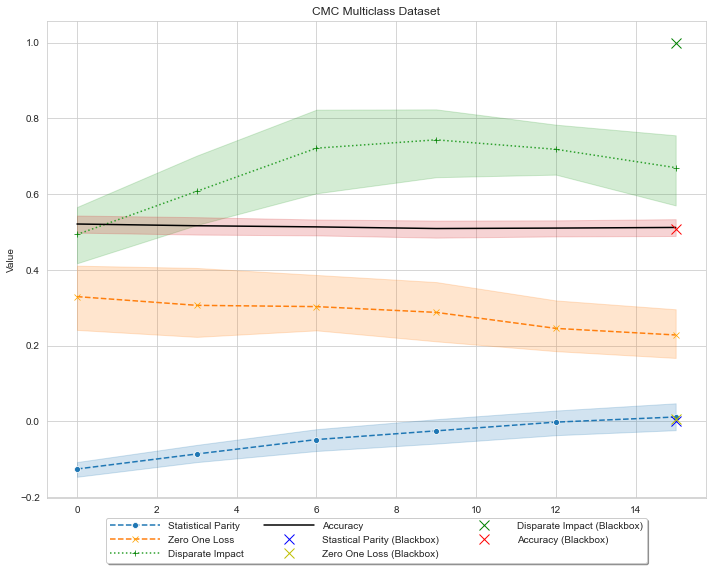

In [ ]:
points = preparepoints(blackboxmetrics, demv.get_iters())
plot_metrics_curves(df, points, title='CMC Multiclass Dataset')

In [ ]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 1473
Unprivileged group size: 955
Percentage of unprivileged group: 64.8336727766463
Number of iterations: 15
